In [3]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits

In [42]:
# Adjust as needed
SAMPLE_PATH = "../samples/2025-02-17T11:43:42.737927"
SAMPLE_PATH = SAMPLE_PATH + "/HMC"
SEED = 10

# Load models

In [54]:
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                y_loc = samples.pop("y_loc", None)
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "az_data": az_data, "samples": samples, "y_loc": y_loc})
print(f"Loaded {len(models)} models")

Loaded 2 models


# Compute Negative-Log-Likelihood, RMSE
To compare with Stein paper, Table 2

In [44]:
# From Stein paper, probably more stable but should be equivalent
def nll_reg_fn(posterior_samples, model, x, y, batch_ndims):
    lls = log_likelihood(model, posterior_samples, X=x, y=y, batch_ndims=batch_ndims)["y"]
    return -(jax.scipy.special.logsumexp(lls, axis=0) - jnp.log(lls.shape[0])).mean()

In [87]:
table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
for row, d in zip(models, table):
    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    samples = row["samples"]
    model = bnns.model_configs.__dict__[row["model"]]
    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[train_split]
    train_y = y[train_split]
    test_X = X[test_split]
    test_y = y[test_split]
    train_nll = -log_likelihood(model, samples, X=train_X, y=train_y, batch_ndims=2)["y"]
    # print(test_X.shape, test_y.shape)
    test_nll = -log_likelihood(model, samples, X=test_X, y=test_y, batch_ndims=2)["y"]

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=2)
    # print(samples.keys())
    predicted_ys = predictive(model_key, X=train_X, y=None, D_Y=1)["y_loc"]
    train_rmse = jnp.sqrt(((train_y - predicted_ys[0,:,:,0])**2).mean())

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=2)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    test_rmse = jnp.sqrt(((test_y - predicted_ys[0,:,:,0])**2).mean())

    d["train_nll"] = train_nll.mean()
    d["test_nll"] = test_nll.mean()
    d["train_rmse"] = train_rmse.item()
    d["test_rmse"] = test_rmse.item()
table_df = pd.DataFrame(table)
table_df

,dataset,model,split,train_nll,test_nll,train_rmse,test_rmse
0,boston-housing,UCI_BNN_2_50,0,2.5504694,3.3669066,2.228759,2.84482
1,boston-housing,UCI_CBNN_2_50,0,2.6840694,3.6017547,2.309351,2.93441


In [88]:
table_df.groupby(["dataset", "model"]).mean()

split train_nll  test_nll  train_rmse  test_rmse
dataset        model                                                          
boston-housing UCI_BNN_2_50     0.0  2.550469  3.366907    2.228759    2.84482
               UCI_CBNN_2_50    0.0  2.684069  3.601755    2.309351    2.93441

# ArviZ posterior predictive check

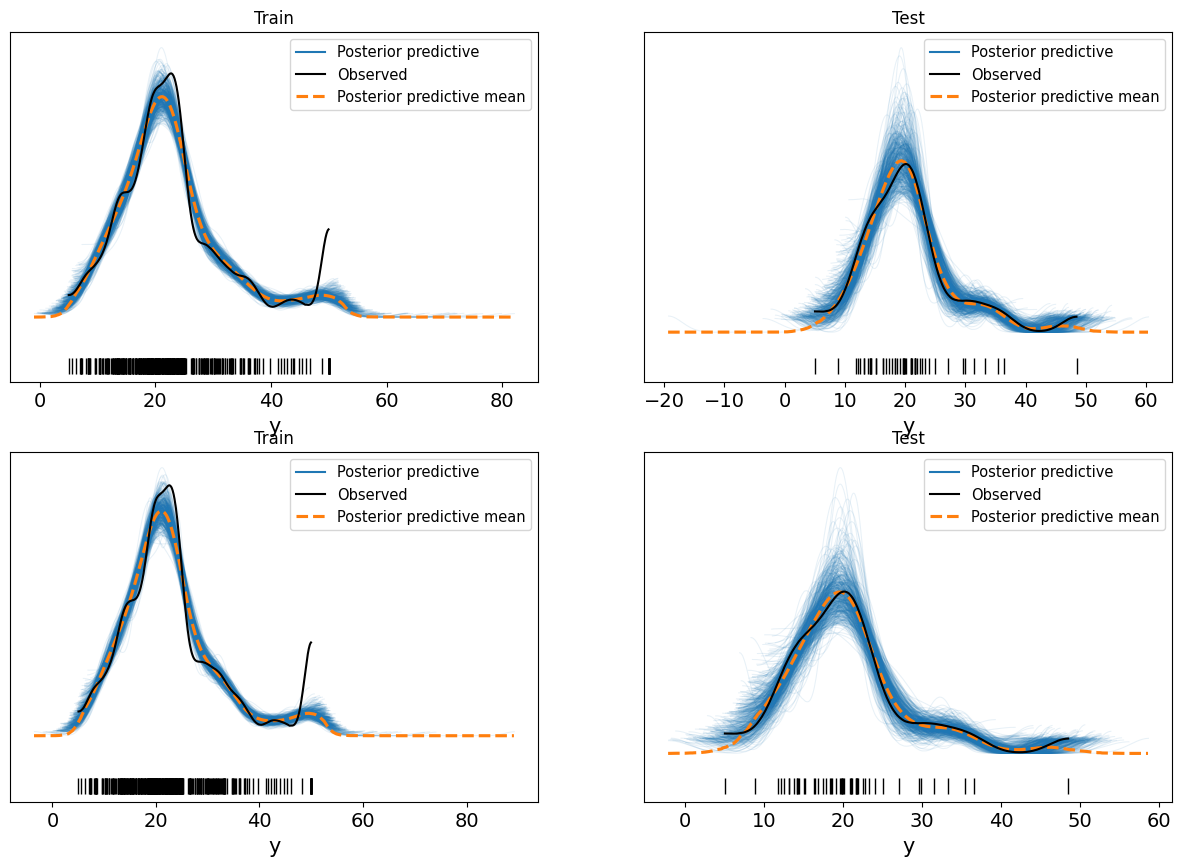

In [38]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
axs = np.array([axs]) if len(models) == 1 else axs
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    predictive = Predictive(model, posterior_samples=d["samples"], return_sites=["y"], batch_ndims=2, parallel=True)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,0].set_title("Train")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,1].set_title("Test")
    

# Plot similar to NumPyro SteinVI example

RMSE: 2.119089365005493
RMSE: 2.1166694164276123


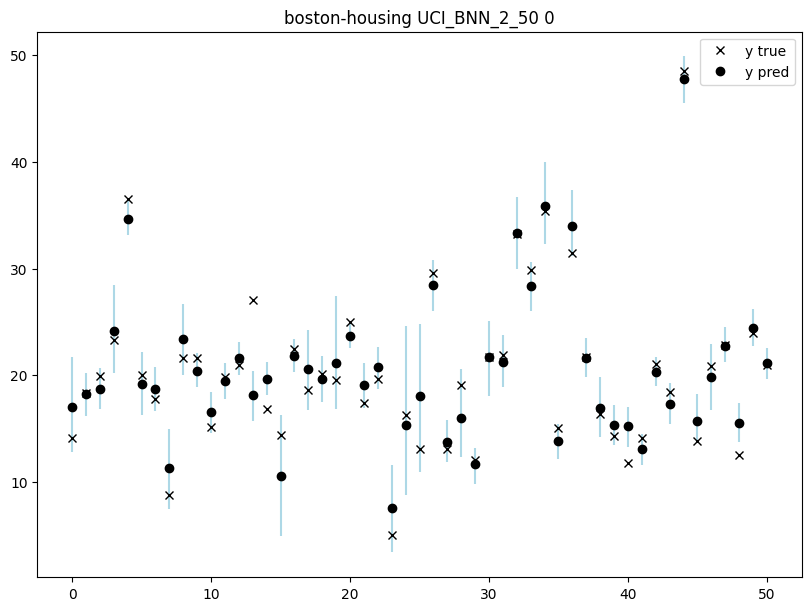

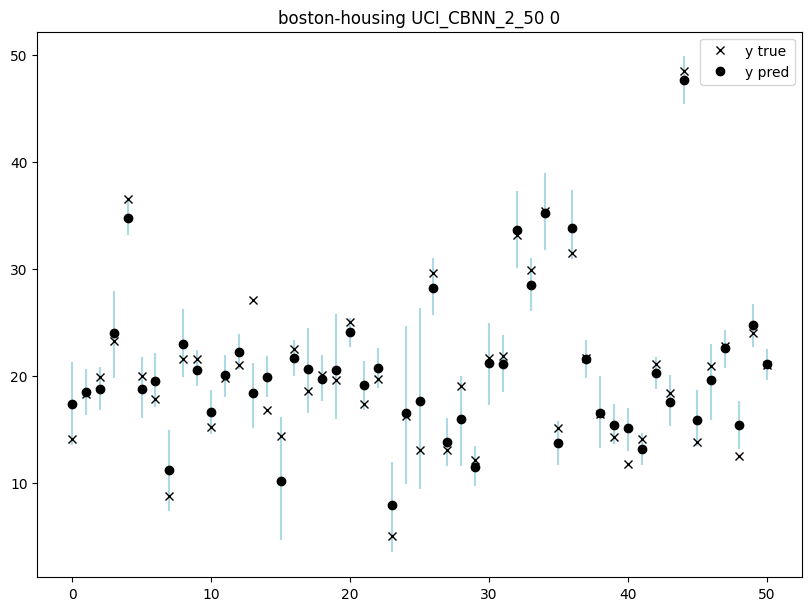

In [81]:
from matplotlib.collections import LineCollection
#fig, axs = plt.subplots(1, len(models), figsize=(8, 6*len(models)), constrained_layout=True)
#axs = axs.ravel()
for d in models:
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    ax.set_title(f"{d['dataset']} {d['model']} {d['split']}")

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]

    predictive = Predictive(bnns.model_configs.__dict__[d["model"]], posterior_samples=d["samples"], return_sites=["y_loc"], batch_ndims=2)
    key = jax.random.PRNGKey(SEED)
    predictive_ys = predictive(key, X=test_X, y=None, D_Y=1)["y_loc"]

    rmse = jnp.sqrt(jnp.mean((predictive_ys[0,:,:,0].mean(0) - test_y) ** 2))
    percentiles = np.percentile(predictive_ys[0,:,:,0], [5, 95], axis=0)
    ran = np.arange(predicted_ys.shape[1])
    ax.add_collection(
        LineCollection(
            zip(zip(ran, percentiles[0]), zip(ran, percentiles[1])), colors="lightblue"
        )
    )
    print(f"RMSE: {rmse}")
    ax.plot(test_y, "kx", label="y true")
    ax.plot(predictive_ys[0].mean(0)[:,0], "ko", label="y pred")
    ax.legend()


In [39]:
import dill
from numpyro import sample, plate, deterministic
from numpyro.distributions import Normal, Gamma
import numpyro.distributions as dist
from jax import nn

def BNN(X, y=None, depth=1, width=4, sigma=1.0, D_Y=None, activation=jnp.tanh):
    # Make sure D_Y is defined
    if y is None and D_Y is None:
        raise ValueError("Either y or D_Y must be provided.")
    if y is not None:
        if y.ndim == 1:
            y = y[..., None]
        D_Y = y.shape[-1]

    N = X.shape[-2]
    D_X = X.shape[-1]
    D_Z = width
    if depth == 1:
        D_Z = D_Y

    # First layer
    w = numpyro.sample("w0", dist.Normal(0.0, 1).expand((D_X, D_Z)))
    b = numpyro.sample("b0", dist.Normal(0.0, 1).expand((D_Z, )))
    z = X @ w + b.flatten()
    z_p = activation(z)

    # Middle layers:
    for i in range(1, depth):
        w = numpyro.sample(f"w{i}", dist.Normal(0.0, 1).expand((D_Z, D_Z)))
        b = numpyro.sample(f"b{i}", dist.Normal(0.0, 1).expand((D_Z,)))
        z = z_p @ w + b
        z_p = activation(z)

    # Last layer
    w = numpyro.sample(f"w{depth}", dist.Normal(0.0, 1).expand((D_Z,D_Y)))
    b = numpyro.sample(f"b{depth}", dist.Normal(0.0, 1).expand((D_Y,)))
    z = (z_p @ w + b).reshape(-1,1)
    if y is not None:
        assert z.shape == y.shape
    else:
        assert z.shape[-1] == D_Y
    with numpyro.plate("data", N):
        y_loc = deterministic("y_loc", z)
        numpyro.sample("y", dist.Normal(y_loc, sigma).to_event(1), obs=y)

def UCI_BNN(X, y=None, depth=2, width=50, D_Y=None):
    prec = numpyro.sample("prec", dist.Gamma(1.0, 0.1))
    _sigma = jnp.sqrt(1 / prec)
    BNN(X, y, depth=depth, width=width, D_Y=D_Y, sigma=_sigma, activation=nn.relu)

def smi_model(x, y):
    """BNN described in appendix D of [1]

    **References:**
        1. Understanding the Variance Collapse of SVGD in High Dimensions
           Jimmy Ba, Murat A. Erdogdu, Marzyeh Ghassemi, Shengyang Sun, Taiji Suzuki, Denny Wu, Tianzong Zhang
    """

    hdim = 50  # Hidden dimension is fixed

    prec = sample("prec", Gamma(1.0, 0.1))

    w1 = sample(
        "w1",
        Normal(0.0, 1).expand(
            (
                x.shape[1] if len(x.shape) > 1 else 1,
                hdim,
            )
        ),
    )  # prior on l1 weights
    b1 = sample("b1", Normal(0.0, 1).expand((hdim,)))  # prior on output bias term

    w2 = sample("w2", Normal(0.0, 1).expand((hdim, hdim)))  # prior on l1 weights
    b2 = sample("b2", Normal(0.0, 1).expand((hdim,)))  # prior on output bias term

    w3 = sample("w3", Normal(0.0, 1).expand((hdim,)))  # prior on output weights

    b3 = sample("b3", Normal(0.0, 1))  # prior on output bias term

    with plate(
        "data",
        x.shape[0],
    ) as idx:
        x_batch = x
        y_batch = y
        # 1 hidden layer with relu activation
        y_loc_p = nn.relu(nn.relu(x_batch @ w1 + b1) @ w2 + b2) @ w3 + b3
        y_loc = deterministic(
            "y_loc", y_loc_p
        )
        sample(
            "y",
            Normal(y_loc, jnp.sqrt(1 / prec)),
            obs=y_batch,
        )

smi_sample_path = "../samples/2025-02-12T15:31:49.515586"
model = lambda x, y: UCI_BNN(X=x, y=y, D_Y=1)
dataset = UCIDataset("boston-housing")
split = load_standard_splits(True)["boston-housing"][0]
with open(os.path.join(smi_sample_path, "boston-housing/bnn/nuts/none/artifact", "0.dill"), "rb") as f:
    artifact = dill.load(f)
samples = artifact["post_draws"]
X = dataset.normalize_X(dataset.data[:, :-1], split)
y = dataset.y
for i in range(3):
    samples[f"w{i}"] = samples.pop(f"w{i+1}")
    samples[f"b{i}"] = samples.pop(f"b{i+1}")

print("NLL ", -log_likelihood(model, samples, X[split["te"]], y[split["te"]], batch_ndims=2)["y"].mean())

def rmse_fn(posterior_samples, y, batch_ndims):
    """Compute the root mean squared error"""

    y_pred = posterior_samples["y_loc"]
    return jnp.sqrt(((y[None] - y_pred) ** 2).mean())

train_y_loc = samples.pop("y_loc", None)
assert train_y_loc is not None
predictive = Predictive(model, posterior_samples=samples, return_sites=["y", "y_loc"], batch_ndims=2)
key = jax.random.PRNGKey(SEED)
predicted_ys = predictive(key, X[split["te"]], None)["y_loc"]
rmse = rmse_fn({"y_loc": predicted_ys}, y[split["te"]], batch_ndims=2)
print("RMSE ", rmse)
# predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
# pred_train_y = predictive(key, X=X[split["tr"]], y=None, D_Y=1)["y"]
# pred_test_y = predictive(key, X=X[split["te"]], y=None, D_Y=1)["y"]

NLL  16190.829
RMSE  10.491224


In [8]:
for model in models:
    az_data = model["az_data"]
    ess = az.ess(az_data)
    sns.pointplot(data=ess, y=ess.data_vars.keys())


In [9]:
ess.data_vars["b0"]

NameError: name 'ess' is not defined

In [10]:
artifact

{'model': None,
 'guide': None,
 'params': None,
 'hyper_params': {'lr': None},
 'post_draws': {'prec': Array([[0.47007948, 0.47976005, 0.47588268, ..., 0.42138174, 0.42835027,
          0.42088836]], dtype=float32),
  'y_loc': Array([[[30.557629 , 23.540201 , 16.544842 , ..., 19.854206 ,
           13.306897 , 22.948927 ],
          [27.71121  , 24.874876 , 17.373001 , ..., 20.129562 ,
           13.991251 , 21.442116 ],
          [29.588762 , 25.360512 , 18.586535 , ..., 20.604664 ,
           13.444028 , 21.29989  ],
          ...,
          [27.948448 , 24.540367 , 19.078539 , ..., 19.65227  ,
           13.37832  , 21.840698 ],
          [29.802168 , 24.389034 , 20.482634 , ..., 19.19399  ,
           13.1453085, 22.23238  ],
          [30.339603 , 24.072792 , 19.382608 , ..., 19.739878 ,
           14.361593 , 22.001156 ]]], dtype=float32),
  'w0': Array([[[[-1.4972149 , -0.240414  , -1.3065985 , ...,  1.0526959 ,
             0.41472426, -1.2383453 ],
           [ 0.28218284,  0

# MCMC diagnostics

## Load metadata

In [11]:
from jax.numpy import float32, int32 , array as Array
metadatas = []
for dataset_name in os.listdir(SAMPLE_PATH):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-12:] == "metadata.txt":
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "r") as f:
                    metadatas.append(eval(f.read()))

# Acceptance probability

In [12]:
import seaborn as sns
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    sns.lineplot(data=data, x="i", y="mean_accept_prob", ax=ax)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

# Precision prior vs posterior

In [13]:
sns.kdeplot(data=d["samples"]["prec"].flatten(), label="posterior")
sns.kdeplot(jax.random.gamma(jax.random.PRNGKey(SEED), 1.0, (10000,))/0.1, label="prior")
plt.legend()

NameError: name 'd' is not defined